# Import Libraries

In [1]:
import pandas as pd
from sqlalchemy import create_engine

# Connect to the Database

In [2]:
# Database connection details
host = "ep-falling-glitter-a5m0j5gk-pooler.us-east-2.aws.neon.tech"
port = "5432"
database = "neondb"
user = "neondb_owner"
password = "npg_CeS9fJg2azZD"

# Create a connection engine
engine = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{database}")


# Run a test Query

In [3]:
# Write a SQL query
query = "SELECT * FROM nyc_schools.high_school_directory LIMIT 5;"

# Execute query and load results directly into pandas
df = pd.read_sql_query(query, engine)

# Preview the data
df.head()


,dbn,school_name,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,number_programs,Location 1,Community Board,Council District,Census Tract,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts
0,27Q260,Frederick Douglass Academy VI High School,Queens,Q465,718-471-2154,718-471-2890,9.0,12,None,None,...,1,"{'latitude': '40.601989336', 'longitude': '-73...",14,31,100802,20529,51,3,47,59
1,21K559,Life Academy High School for Film and Music,Brooklyn,K400,718-333-7750,718-333-7775,9.0,12,None,None,...,1,"{'latitude': '40.593593811', 'longitude': '-73...",13,47,306,17616,21,2,45,35
2,16K393,Frederick Douglass Academy IV Secondary School,Brooklyn,K026,718-574-2820,718-574-2821,9.0,12,None,None,...,1,"{'latitude': '40.692133704', 'longitude': '-73...",3,36,291,18181,69,2,49,52
3,08X305,Pablo Neruda Academy,Bronx,X450,718-824-1682,718-824-1663,9.0,12,None,None,...,1,"{'latitude': '40.822303765', 'longitude': '-73...",9,18,16,11611,58,5,31,26
4,03M485,Fiorello H. LaGuardia High School of Music & A...,Manhattan,M485,212-496-0700,212-724-5748,9.0,12,None,None,...,6,"{'latitude': '40.773670507', 'longitude': '-73...",7,6,151,12420,20,4,19,12


# Data Exploration

In [4]:
pd.read_sql_query("""
SELECT table_schema, table_name
FROM information_schema.tables
WHERE table_schema NOT IN ('pg_catalog','information_schema')
ORDER BY 1,2;
""", engine)

,table_schema,table_name
0,dependency_example,banks_test_kovalivska_aws
1,dependency_example,departments
2,dependency_example,districts
3,dependency_example,employees
4,dependency_example,martin_svitek_sat_results
...,...,...
57,test_berlin_data,neighborhoods
58,test_berlin_data,neon_test_products_v3
59,test_berlin_data,simple_products
60,test_berlin_data,users_test


# Q & A

How many schools are there in each borough?

In [10]:
query = """
SELECT borough, COUNT(DISTINCT dbn) AS total_schools
FROM nyc_schools.high_school_directory
GROUP BY 1
ORDER BY 2 DESC
"""
df2 = pd.read_sql_query(query, engine)
print(df2)

         borough  total_schools
0       Brooklyn            121
1          Bronx            118
2      Manhattan            106
3         Queens             80
4  Staten Island             10


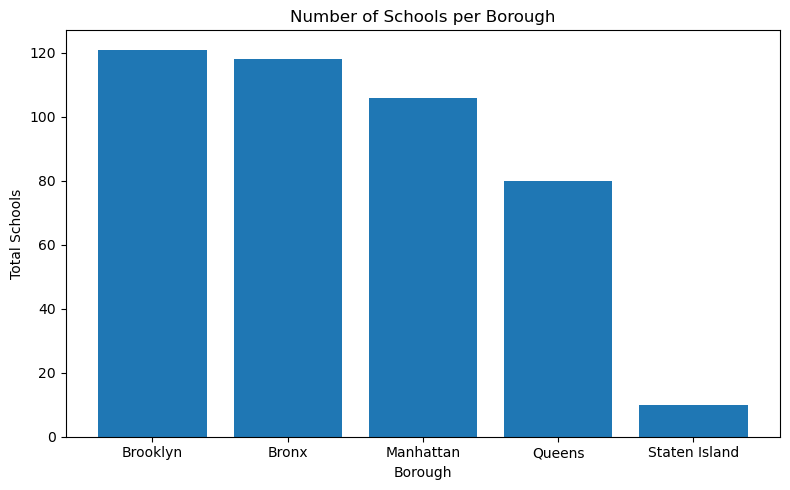

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.bar(df2["borough"], df2["total_schools"])
plt.title("Number of Schools per Borough")
plt.xlabel("Borough")
plt.ylabel("Total Schools")
plt.tight_layout()
plt.show()

What is the average % of English Language Learners (ELL) per borough?

In [7]:
query = """
SELECT d.borough,
       ROUND(AVG(sd.ell_percent::numeric), 2) AS avg_ell_percent,
       COUNT(sd.ell_percent) AS schools_used
FROM nyc_schools.high_school_directory d
LEFT JOIN nyc_schools.school_demographics sd ON sd.dbn = d.dbn
GROUP BY d.borough
ORDER BY avg_ell_percent DESC NULLS LAST
"""
df_ell = pd.read_sql_query(query, engine)
print(df_ell)

         borough  avg_ell_percent  schools_used
0      Manhattan             7.57            40
1       Brooklyn              NaN             0
2         Queens              NaN             0
3  Staten Island              NaN             0
4          Bronx              NaN             0


Using the data from the school demographics and high school directory, write a query to find the top 3 schools in each borough with the highest percentage of special education students (sped_percent)

In [8]:
query3 = """
WITH schools AS (
  SELECT
      sch.dbn,
      sch.school_name,
      sch.borough,
      dem.schoolyear,
      dem.sped_percent::numeric AS sped_percent,
      ROW_NUMBER() OVER (
        PARTITION BY sch.borough
        ORDER BY dem.sped_percent::numeric DESC
      ) AS rn
  FROM nyc_schools.high_school_directory AS sch
  JOIN nyc_schools.school_demographics AS dem
    ON sch.dbn = dem.dbn
  WHERE dem.sped_percent IS NOT NULL
)
SELECT borough, dbn, school_name, schoolyear, sped_percent
FROM schools
WHERE rn <= 3
ORDER BY borough, sped_percent DESC, school_name;
"""
df_sped = pd.read_sql_query(query3, engine)
print(df_sped)

     borough     dbn                 school_name  schoolyear  sped_percent
0  Manhattan  01M450  East Side Community School    20092010          28.8
1  Manhattan  01M450  East Side Community School    20102011          27.7
2  Manhattan  01M450  East Side Community School    20082009          26.7


# Observations

- Manhattan has the top 3 schools with the highest percentageof special education students
- Brooklyn has the highest number of schools, 121, followed by Bronx, 118